In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

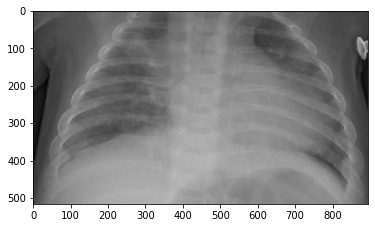

In [2]:
#training paths config
#Covid19
covid_path_train = r"../input/chest-xray-pneumoniacovid19tuberculosis/train/COVID19"
covid_images_train = os.listdir(r"../input/chest-xray-pneumoniacovid19tuberculosis/train/COVID19")
covid_filepaths = [covid_path_train + '/' + img_id for img_id in covid_images_train]
#Normal
normal_path_train = r"../input/chest-xray-pneumoniacovid19tuberculosis/train/NORMAL"
normal_images_train = os.listdir(r"../input/chest-xray-pneumoniacovid19tuberculosis/train/NORMAL")
normal_filepaths = [normal_path_train + '/' + img_id for img_id in normal_images_train]
#Pneumonia
pneumonia_path_train = r"../input/chest-xray-pneumoniacovid19tuberculosis/train/PNEUMONIA"
pneumonia_images_train = os.listdir(r"../input/chest-xray-pneumoniacovid19tuberculosis/train/PNEUMONIA")
pneumonia_filepaths = [pneumonia_path_train + '/' + img_id for img_id in pneumonia_images_train]
#Tuberculosis
turberculosis_path_train = r"../input/chest-xray-pneumoniacovid19tuberculosis/train/TURBERCULOSIS"
turberculosis_images_train = os.listdir(r"../input/chest-xray-pneumoniacovid19tuberculosis/train/TURBERCULOSIS")
turberculosis_filepaths = [turberculosis_path_train + '/' + img_id for img_id in turberculosis_images_train]

#importation test
img = plt.imread(pneumonia_filepaths[4])
plt.imshow(img)
plt.show()

In [3]:
#Data Preprocessing
def proc_img(filepath):
    #Create a DataFrame with the filepath and the labels of the pictures
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [4]:
covid_df = proc_img(covid_filepaths)
normal_df = proc_img(normal_filepaths)
pneumonia_df = proc_img(pneumonia_filepaths)
turberculosis_df = proc_img(turberculosis_filepaths)
covid_df.head(1),normal_df.head(1),pneumonia_df.head(1),turberculosis_df.head(1)

(                                            Filepath    Label
 0  ../input/chest-xray-pneumoniacovid19tuberculos...  COVID19,
                                             Filepath   Label
 0  ../input/chest-xray-pneumoniacovid19tuberculos...  NORMAL,
                                             Filepath      Label
 0  ../input/chest-xray-pneumoniacovid19tuberculos...  PNEUMONIA,
                                             Filepath          Label
 0  ../input/chest-xray-pneumoniacovid19tuberculos...  TURBERCULOSIS)

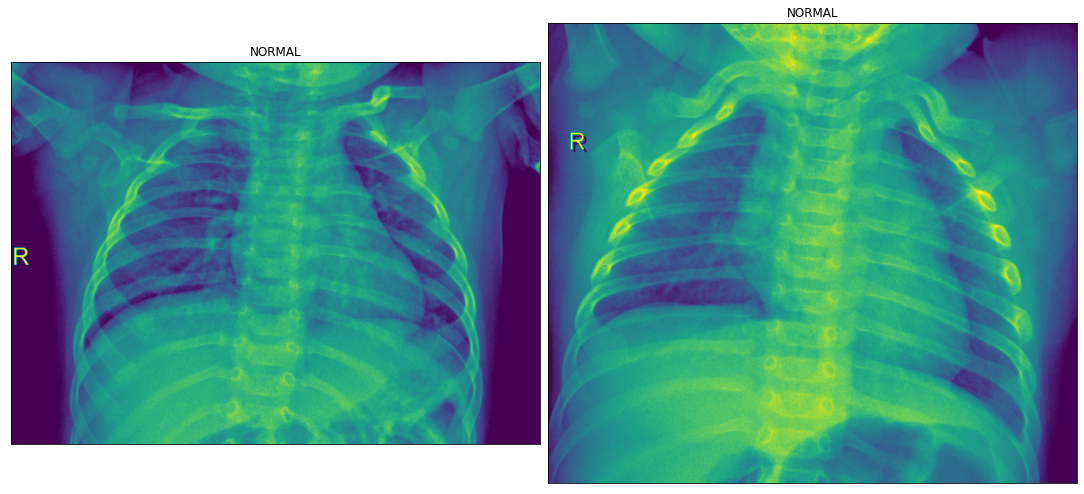

In [5]:
# Display 2 picture of the Normal dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(normal_df.Filepath[i]))
    ax.set_title(normal_df.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

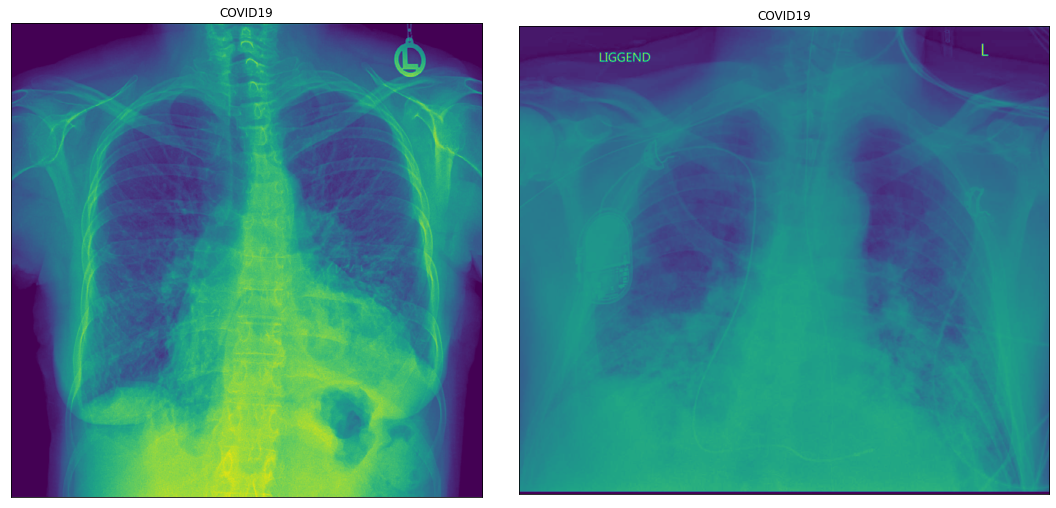

In [6]:
# Display 2 picture of the Covid dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(covid_df.Filepath[i]))
    ax.set_title(covid_df.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

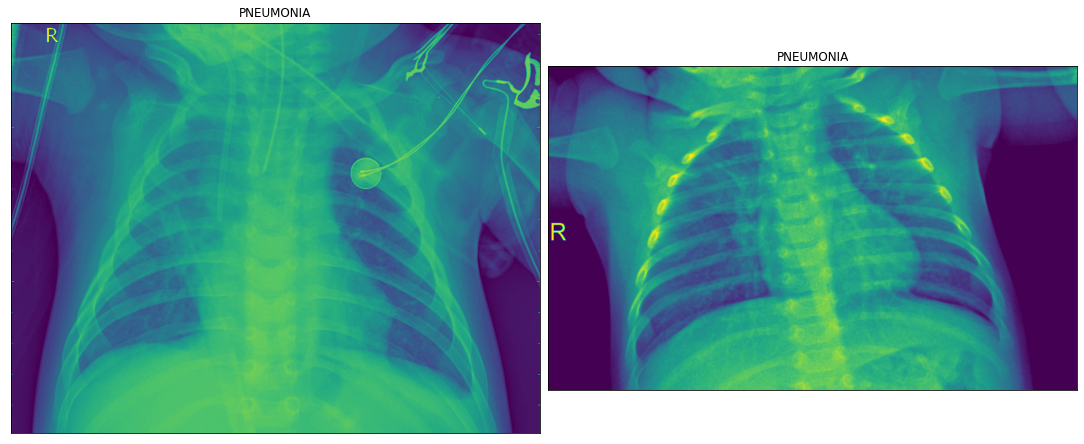

In [7]:
# Display 2 pictures of the Pnedumonia dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(pneumonia_df.Filepath[i]))
    ax.set_title(pneumonia_df.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

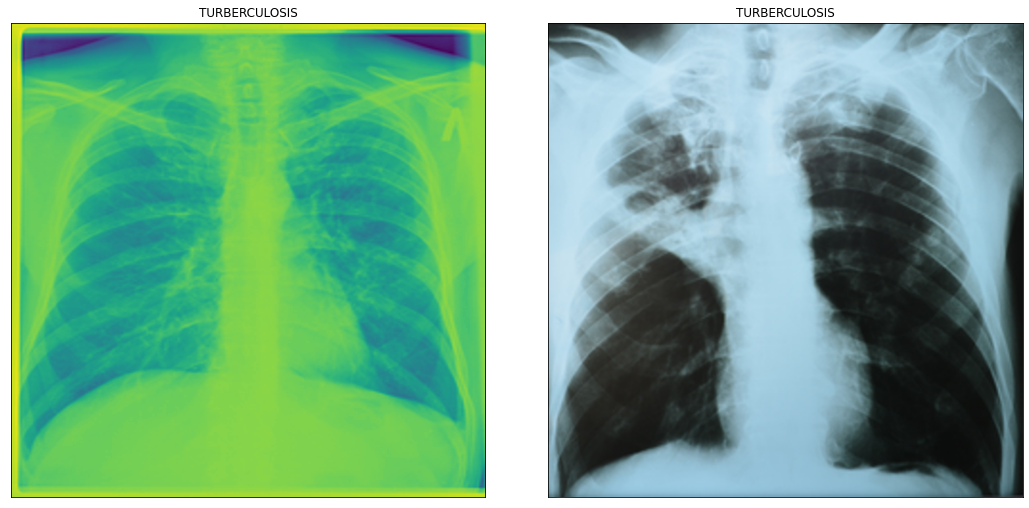

In [8]:
# Display 2 pictures of the Turberculosis dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(turberculosis_df.Filepath[i]))
    ax.set_title(turberculosis_df.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

In [9]:
df = pd.concat([covid_df, normal_df, turberculosis_df, pneumonia_df], axis=0)
display(df)

,Filepath,Label
0,../input/chest-xray-pneumoniacovid19tuberculos...,COVID19
1,../input/chest-xray-pneumoniacovid19tuberculos...,COVID19
2,../input/chest-xray-pneumoniacovid19tuberculos...,COVID19
3,../input/chest-xray-pneumoniacovid19tuberculos...,COVID19
4,../input/chest-xray-pneumoniacovid19tuberculos...,COVID19
...,...,...
3870,../input/chest-xray-pneumoniacovid19tuberculos...,PNEUMONIA
3871,../input/chest-xray-pneumoniacovid19tuberculos...,PNEUMONIA
3872,../input/chest-xray-pneumoniacovid19tuberculos...,PNEUMONIA
3873,../input/chest-xray-pneumoniacovid19tuberculos...,PNEUMONIA


In [10]:
df.Label.value_counts(), len(df.Label)

(PNEUMONIA        3875
 NORMAL           1341
 TURBERCULOSIS     650
 COVID19           460
 Name: Label, dtype: int64,
 6326)

In [11]:
#train test split
# Take a .25 sample from the data frame
int(len(df) * 0.25)    #  >> num of test images

1581

In [12]:
test_df = df.sample(n=1581,random_state=42)
test_df.Label.value_counts()

PNEUMONIA        964
NORMAL           351
TURBERCULOSIS    133
COVID19          133
Name: Label, dtype: int64

In [13]:
train_df = df.merge(test_df, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
train_df.Label.value_counts()

PNEUMONIA        2911
NORMAL            990
TURBERCULOSIS     517
COVID19           327
Name: Label, dtype: int64

In [14]:
len(train_df.Label)

4745

In [15]:
# Train generator
train_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 4745 validated image filenames belonging to 4 classes.


In [16]:
# Test generator
test_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 1581 validated image filenames belonging to 4 classes.


In [17]:
model= Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(120,120,1,)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(4,activation = 'softmax'))  # the output layer

2022-06-22 10:38:24.181237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 10:38:24.336245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 10:38:24.337131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 10:38:24.338394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 30)      8670      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 30)        8130      
_________________________________________________________________
flatten (Flatten)            (None, 20280)             0

In [19]:
#Early stop setup
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(train_images, epochs = 12 , validation_data = test_images, verbose=1, callbacks=early_stop)

2022-06-22 10:38:27.955577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2022-06-22 10:38:29.840093: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


149/149 [==============================] - 116s 728ms/step - loss: 1.0787 - accuracy: 0.6110 - val_loss: 1.0318 - val_accuracy: 0.6097
Epoch 2/12
149/149 [==============================] - 75s 507ms/step - loss: 0.5608 - accuracy: 0.7785 - val_loss: 0.3229 - val_accuracy: 0.8937
Epoch 3/12
149/149 [==============================] - 76s 508ms/step - loss: 0.3402 - accuracy: 0.8738 - val_loss: 0.3132 - val_accuracy: 0.8754
Epoch 4/12
149/149 [==============================] - 76s 510ms/step - loss: 0.2802 - accuracy: 0.8982 - val_loss: 0.2498 - val_accuracy: 0.9140
Epoch 5/12
149/149 [==============================] - 75s 504ms/step - loss: 0.2471 - accuracy: 0.9087 - val_loss: 0.2603 - val_accuracy: 0.9102
Epoch 6/12
149/149 [==============================] - 75s 502ms/step - loss: 0.2321 - accuracy: 0.9153 - val_loss: 0.2101 - val_accuracy: 0.9241
Epoch 7/12
149/149 [==============================] - 76s 507ms/step - loss: 0.2021 - accuracy: 0.9241 - val_loss: 0.2064 - val_accuracy: 0.

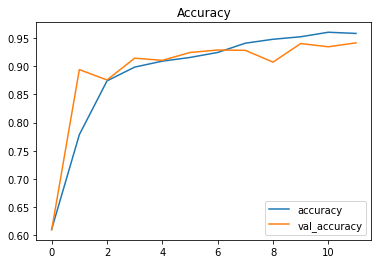

In [20]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy") 
plt.show()

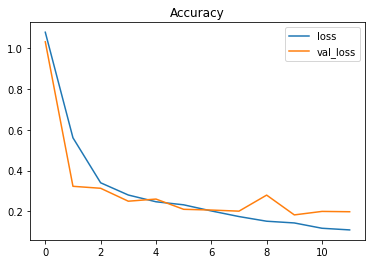

In [21]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()
plt.title("Accuracy") 
plt.show()  

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID19', 'PNEUMONIA', 'TURBERCULOSIS', 'COVID19']


In [23]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("final_CNN.h5")
print("Final CNN Saved model to disk")

Final CNN Saved model to disk
